# Systematic comparison of the implemented algorithms

In [35]:
'''IMPORTS'''

import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import sys
import random
import copy
from datetime import datetime
from tqdm import tqdm


from collections import deque
from queue import PriorityQueue
from utilsMinihackSearch import *
from typing import Tuple, List

In [36]:
'''LOAD ALGORITHMS'''

'''LOAD HILL CLIMBING'''
# Function to perform hill climbing algorithm to find a path from start to target
def hill_climb(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # Initialize the current state with the start position
    current = {'state': start}
    # Initialize the parent dictionary to track paths
    parent = {start: None}  
    # Continue the loop until a solution is found or an appropriate condition is met
    while True:
        # Find the highest valued successor based on the heuristic
        neighbor = highest_valued_successors(current, game_map, target, h)
        # Check if the heuristic value of the neighbor is less than or equal to the current state
        if h(neighbor['state'], target) >= h(current['state'], target):
            # If true, construct and return the path
            path = build_path_HillClimb(parent, start, target)
            return path
        
        # Update the parent dictionary with the current and neighbor states
        parent[neighbor['state']] = current['state']
        # Move to the neighbor state for the next iteration
        current = neighbor
        
        # Debugging statements
        # print("Parent dictionary:", parent)  
        # print("Target:", target)
        # print("Current state:", current['state'])

# Function to build the path from the parent dictionary
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target
    
    # Continue until reaching the start or a dead end
    while current is not None and current != start:
        # Append the current state to the path
        path.append(current)
        # Check if the current state is not in the parent dictionary
        if current not in parent:
            print(f"Target {target} not reachable from start {start}.")
            return None
        # Move to the parent state for backtracking
        current = parent[current]
    
    # Add the starting point to the path and reverse the order
    path.append(start)
    path.reverse()
    
    return path

# Function to find the highest valued successor based on the heuristic
def highest_valued_successors(node, game_map, target, h):
    # Get valid moves (successors) from the current state
    successors = get_valid_moves(game_map, node['state'])
    # Sort successors based on the heuristic value in descending order
    successors.sort(key=lambda x: h(x, target), reverse=True)
    successors.reverse()
    # Return the highest valued successor
    return {'state': successors[0]}

env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/empty.des",
)
state = env.reset()

'''LOAD HILL CLIMBING WITH BACKTRACKING'''
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target

    while current is not None and current != start:
        path.append(current)
        current = parent[current]

    path.append(start)  # Add the starting point to the path
    path.reverse()

    return path

def hill_climb_backtracking(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # initialize open and close list
    open_list = [start]
    close_list = []
    parent = {start: None}

    while open_list:
        # getting the current node
        current = open_list.pop()
        # adding the node to the close list
        close_list.append(current)

        if current == target:
            path = build_path_HillClimb(parent, start,target)
            return path

        for neighbor in get_valid_moves(game_map, current):
            # check if neighbor in close list, if so continue
            if neighbor in close_list:
                continue

            # compute neighbor h value
            neighbor_h = h(neighbor, target)
            parent[neighbor] = current
            # if neighbor not in open list, adding it
            if neighbor not in open_list:
                open_list.append(neighbor)

    return None

'''LOAD LOCAL BEAM SEARCH'''
import random
import time


def initialize_states(game_map: np.ndarray, start: Tuple[int, int], k: int):

    init_states = [list(random.choice(get_valid_moves(game_map, start))) for _ in range(k)]
    
    current_states = []
    for state in init_states:
        current_states.append({
            'current': tuple(state),
            'explored_nodes': [tuple(state)],
            'path': [tuple(state)]
        })

    return current_states

def get_successors_from_states(game_map: np.ndarray, states: list):

    state_neighbors = []

    for state in states:
        neighbors = get_valid_moves(game_map, state['current'])
        state_neighbors.append({
            'path': state['path'],
            'explored_nodes': state['explored_nodes'],
            'possible_moves': neighbors
        })
        

    return state_neighbors

def get_heuristic_scores(heuristic: callable, neighbors: list):

    scored_moves = []

    for state in neighbors:
        for move in state['possible_moves']:
            score_target = heuristic(move, target)
            score_start = heuristic(start, move)
            scored_moves.append({
                'path': state['path'],
                'explored_nodes': state['explored_nodes'],
                'current': move,
                'distance_from_target': score_target,
                'distance_from_start': score_start
            })
    
    return scored_moves

def assign_probabilities(sorted_array):
    n = len(sorted_array)
    probabilities = [1 / (i + 1) for i in range(n)]
    
    # give the same probability if two elements has the same distance
    for i in range(1, n):
        if sorted_array[i] == sorted_array[i - 1]:
            probabilities[i] = probabilities[i - 1]
    
    return probabilities

def get_next_states(scored_successors: list, k: int, stocastic: bool):

    scored_successors_from_target = sorted(scored_successors, key = lambda x: x['distance_from_target'])
    scored_successors_from_start = sorted(scored_successors, key = lambda x: x['distance_from_start'], reverse=True)
    scored_successors = None

    if scored_successors_from_start[0]['distance_from_start'] - 15 < scored_successors_from_target[0]['distance_from_target'] :
        scored_successors = scored_successors_from_start
    else:
        scored_successors = scored_successors_from_target

    # scored_successors = scored_successors_from_start

    top = []

    if stocastic:
        cont = 0
        while cont < k:
            # top.append(scored_successors[random.randrange(0, len(scored_successors))])
            probability_array = assign_probabilities(scored_successors)
            choice = random.choices(scored_successors, probability_array)[0]
            if choice not in top:
                top.append(choice)
                cont += 1
    else:
        cont = 0
        for succ in scored_successors:
            if cont < k:
                if succ['current'] not in succ['explored_nodes']:
                    succ['explored_nodes'] = succ['explored_nodes'] + [succ['current']]
                    top.append(succ)
                    cont += 1

                
    
    next_states = list()
    
    for s in top:
        next_states.append({
            'current': s['current'],
            'explored_nodes': s['explored_nodes'],
            'path': s['path'] + [s['current']]
        })
    
    return next_states


def local_beam_search(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], heuristic: callable, k: int = 3, max_iter: int = 100, stocastic: bool = False):

    current_states = initialize_states(game_map, start, k)

    for i in range(max_iter):

        state_neighbors = get_successors_from_states(game_map, current_states)

        if len(current_states) == 0 or i == max_iter - 1:
            path = [start] + backup_states[0]['path'] + [move]
            return None
        
        # check if a possible move is the target
        for state in state_neighbors:
            for move in state['possible_moves']:
                if move == target:
                   path = [start] + state['path'] + [move]
                   return path

        scored_successors = get_heuristic_scores(heuristic, state_neighbors)
        backup_states = current_states
        current_states = get_next_states(scored_successors, k, stocastic)

'''LOAD SIMULATED ANNEALING'''
def exp_schedule(t: float, annealing: float):
    """One possible schedule function for simulated annealing"""
    return t * annealing

def assign_probabilities(sorted_array, deltas, t):
    n = len(sorted_array)
    if t < 0.01:
        probabilities = [1] + [0] * (n - 1)
    else:
        probabilities = [math.exp(-deltas[i] / t) for i in range(n)]
    return probabilities

def ordered_successors(node, game_map, target, h):
    successors = get_valid_moves(game_map, node['state'])
    successors.sort(key=lambda x: h(x, target), reverse=True)
    successors.reverse()
    return successors

def calcolo_delta(neighbors, current, h, target):
    deltas = []
    n = len(neighbors)
    current_hValue = h(current['state'], target)
    for i in range(n):
        x = h(neighbors[i], target)
        deltas.append(x - current_hValue)
    return deltas

def simulated_annealing(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable, T: float, annealing: float) -> List[Tuple[int, int]]:
    path = []
    current = {'state': start}
    startt = {'state': start}
    path.append(start)
    while True: 
        if T > 0:
            T = exp_schedule(T, annealing)
        neighbors = ordered_successors(current, game_map, target, h)
        deltas = calcolo_delta(neighbors, startt, h, target)
        probabilities = assign_probabilities(neighbors, deltas, T)
        # print(f"deltas: {deltas},   prob: {probabilities}, T: {T}")
        choice = random.choices(neighbors, probabilities)[0]
        path.append(choice)
        current = {'state': choice}
        # print(f"choice: {current}")
        if current['state'] == target:
            return path, True
        if len(path) == 150:
            return path, False

### First maze

Agent position: (16, 33)
Target position: (6, 43)


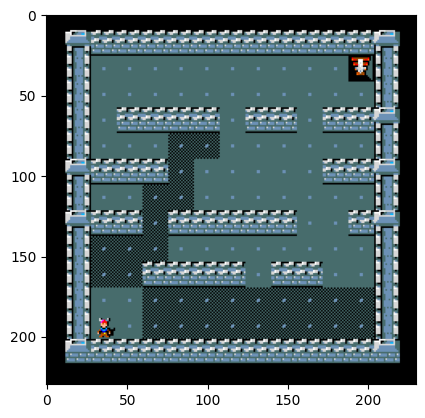

In [37]:
'''LOAD SIMPLE MAZE'''
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/comparison_mazes/maze1.des",
)
state = env.reset()

game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

plt.imshow(state['pixel'][70:300, 500:730])

In [38]:
'''TEST SIMPLE MAZE'''
correct_paths = {
    'Hill Climbing Search': 0,
    'Hill Climbing with Backtracking': 0,
    'Local Beam Search': 0,
    'Simulated Annealing': 0
    }
dynamicAnnealing = 0.002
numIter = 100
for i in range(numIter):
    path = hill_climb(game_map, start, target, manhattan_distance)
    if path is not None:
        correct_paths['Hill Climbing Search'] = correct_paths.get('Hill Climbing Search', 0) + 1

    path = hill_climb_backtracking(game_map, start, target, manhattan_distance)
    if path is not None:
        correct_paths['Hill Climbing with Backtracking'] = correct_paths.get('Hill Climbing with Backtracking', 0) + 1

    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path:
        correct_paths['Local Beam Search'] = correct_paths.get('Local Beam Search', 0) + 1

    path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = dynamicAnnealing)
    if isPathFound:
        correct_paths['Simulated Annealing'] = correct_paths.get('Simulated Annealing', 0) + 1
    dynamicAnnealing = dynamicAnnealing + 0.002

print("In " + str(numIter) +  " tests,")
print("Hill Climbing Search has found " + str(correct_paths.get('Hill Climbing Search', 0)) +" correct paths (" + str(correct_paths.get('Hill Climbing with Backtracking', 0)) + " with the Backtracking variation);")
print("Local Beam Search found " + str(correct_paths.get('Local Beam Search', 0)) + ";")
print("Finally, Simulated Annealing found " + str(correct_paths.get('Simulated Annealing', 0)) + ";")

In 100 tests,
Hill Climbing Search has found 100 correct paths (100 with the Backtracking variation);
Local Beam Search found 52;
Finally, Simulated Annealing found 100;


### Second maze

Agent position: (6, 43)
Target position: (15, 36)


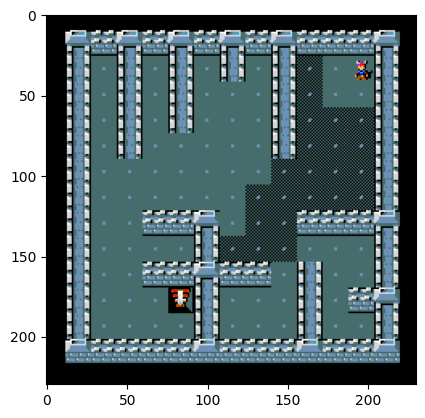

In [39]:
'''LOAD HARD-ISH MAZE'''
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/comparison_mazes/maze2.des",
)
state = env.reset()

game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

plt.imshow(state['pixel'][70:300, 500:730])

In [40]:
'''TEST HARD-ISH MAZE'''
correct_paths = {
    'Hill Climbing Search': 0,
    'Hill Climbing with Backtracking': 0,
    'Local Beam Search': 0,
    'Simulated Annealing': 0
    }
dynamicAnnealing = 0.002
numIter = 100
for i in range(numIter):
    path = hill_climb(game_map, start, target, manhattan_distance)
    path = None
    if path is not None:
        correct_paths['Hill Climbing Search'] = correct_paths.get('Hill Climbing Search', 0) + 1

    path = hill_climb_backtracking(game_map, start, target, manhattan_distance)
    if path is not None:
        correct_paths['Hill Climbing with Backtracking'] = correct_paths.get('Hill Climbing with Backtracking', 0) + 1

    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path:
        correct_paths['Local Beam Search'] = correct_paths.get('Local Beam Search', 0) + 1

    path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = dynamicAnnealing)
    if isPathFound:
        correct_paths['Simulated Annealing'] = correct_paths.get('Simulated Annealing', 0) + 1
    dynamicAnnealing = dynamicAnnealing + 0.002

print("In " + str(numIter) +  " tests,")
print("Hill Climbing Search has found " + str(correct_paths.get('Hill Climbing Search', 0)) +" correct paths (" + str(correct_paths.get('Hill Climbing with Backtracking', 0)) + " with the Backtracking variation);")
print("Local Beam Search found " + str(correct_paths.get('Local Beam Search', 0)) + ";")
print("Finally, Simulated Annealing found " + str(correct_paths.get('Simulated Annealing', 0)) + ";")

KeyError: (15, 36)

### Third maze

Agent position: (10, 39)
Target position: (19, 44)


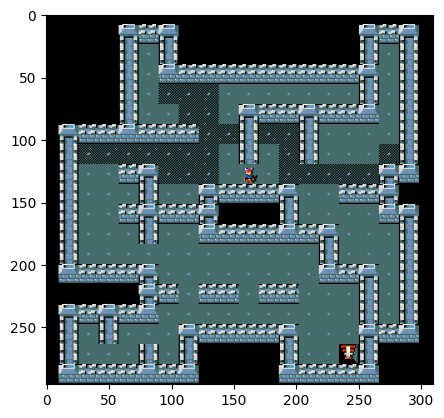

In [31]:
'''LOAD HARD MAZE'''
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/comparison_mazes/maze3.des",
)
state = env.reset()

game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

plt.imshow(state['pixel'][40:450, 470:780])

In [34]:
'''TEST HARD MAZE'''
correct_paths = {
    'Hill Climbing Search': 0,
    'Hill Climbing with Backtracking': 0,
    'Local Beam Search': 0,
    'Simulated Annealing': 0
    }
dynamicAnnealing = 0.002
numIter = 1000
for i in range(numIter):
    #path = hill_climb(game_map, start, target, manhattan_distance)
    path = None
    if path is not None:
        correct_paths['Hill Climbing Search'] = correct_paths.get('Hill Climbing Search', 0) + 1

    path = hill_climb_backtracking(game_map, start, target, manhattan_distance)
    if path is not None:
        correct_paths['Hill Climbing with Backtracking'] = correct_paths.get('Hill Climbing with Backtracking', 0) + 1

    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path:
        correct_paths['Local Beam Search'] = correct_paths.get('Local Beam Search', 0) + 1

    path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = dynamicAnnealing)
    if isPathFound:
        correct_paths['Simulated Annealing'] = correct_paths.get('Simulated Annealing', 0) + 1
    dynamicAnnealing = dynamicAnnealing + 0.002

print("In " + str(numIter) +  " tests,")
print("Hill Climbing Search has found " + str(correct_paths.get('Hill Climbing Search', 0)) +" correct paths (" + str(correct_paths.get('Hill Climbing with Backtracking', 0)) + " with the Backtracking variation);")
print("Local Beam Search found " + str(correct_paths.get('Local Beam Search', 0)) + ";")
print("Finally, Simulated Annealing found " + str(correct_paths.get('Simulated Annealing', 0)) + ";")

OverflowError: math range error